# Modelo de Rede Neural

#### Imports das bibliotecas utilizadas

In [1]:
### https://developer.nvidia.com/cuda-downloads

import pandas as pd

import tensorflow as tf
from keras import backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, f1_score

import seaborn as sns
import matplotlib.pyplot as plt

import nltk

#### Definindo seed globalmente

In [2]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)

#### Carregamento do dataset

In [3]:
USE_ALL_DATA=False

df = pd.read_csv('../dados/amostra.sample.final.full.csv')
df['texto_clean_pure'].replace(' ', np.nan, inplace=True)
df.drop(df.columns.difference(['categoria_binaria','texto_clean_pure']), axis=1, inplace=True)
df.dropna(subset=['texto_clean_pure'], inplace=True)
if not USE_ALL_DATA:
    df = df.sample(n=7020*2, random_state=80)

print('Shape: {}'.format(df.shape))

Shape: (14040, 2)


In [ ]:
df.head()

#### Definição de hiperparâmetros

In [6]:
oov_tok = "<UKN>"
vocab_size = 100000

# output directory name
output_dir = 'model_output/dense'

# training:
epochs = 40
batch_size = 512

# vector-space embedding:
n_dim = 16
n_unique_words = vocab_size + 1
n_words_to_skip = 50


# newral network architecture:
n_dense = 64
dropout = 0.5

# Optimizer
base_learning_rate = 0.0001

# padding
padding_type = trunc_type  = 'pre' # or'post'
##### Set hyperparameters - END

plt.rcParams.update({'font.size': 18})

#### Funções utilitárias

In [9]:
def _vectorize(X):
    # intializing a tokenizer that can index
    # num_words is the maximum number words that can be kept 
    # tokenizer will automatically help in choosing most frequent words
    tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

    # fitting the sentences to using created tokenizer object
    tokenizer.fit_on_texts(X)
    # the full list of words is available as the tokenizer's word index
    word_index_items = tokenizer.word_index.items()

    # this creates sequence of tokens representing each sentence
    sequences = tokenizer.texts_to_sequences(X)

    return sequences, word_index_items, tokenizer.word_counts

# Function takes a tokenized sentence and returns the words
def sequence_to_text(list_of_indices, word_index_items):
    reverse_word_map = dict(map(reversed, word_index_items))

    # Looking up words in dictionary
    words = [reverse_word_map.get(letter) for letter in list_of_indices]
    return(words)

def calcula_frequencias(df, column_name, n_words=20):
    todas_palavras = ' '.join([texto for texto in df[column_name]])
    token_espaco = nltk.WhitespaceTokenizer()
    token_frase = token_espaco.tokenize(todas_palavras)
    frequencia = nltk.FreqDist(token_frase)

    df_frequencia = pd.DataFrame({'palavra': list(frequencia.keys()),
                                'frequencia': list(frequencia.values())})

    nlargest = df_frequencia.nlargest(columns='frequencia', n=n_words)
    nsmallest = df_frequencia.nsmallest(columns='frequencia', n=n_words)

    return nlargest, nlargest['palavra'].values, nsmallest['palavra'].values

def chart_frequencia_palavras(df, column_name, n_words):
    calculo_frequencia = calcula_frequencias(df, column_name=column_name, n_words=n_words)
    df_frequencia = calculo_frequencia[0]

    total = df_frequencia['frequencia'].sum()
    df_frequencia['cumsum'] = df_frequencia['frequencia'].cumsum()
    df_frequencia['porcentagem'] = df_frequencia['frequencia'].cumsum() / total * 100

    plt.figure(figsize=(12,8))
    ax = sns.barplot(data=df_frequencia, x='palavra', y='frequencia')
    for item in ax.get_xticklabels():
        item.set_rotation(45)
    
    ax2 = ax.twinx()
    sns.lineplot(data=df_frequencia, x='palavra', y="porcentagem", sort=False, ax=ax2, color="Red")

    plt.show()

def chart_palavras_por_documento(sequences):
    min_palavras = 0
    df_length_sequences = pd.DataFrame([len(x) for x in sequences], columns=['length'])

    df_length_x_documentos = pd.DataFrame({'qtd_documentos' : df_length_sequences.groupby(['length'])['length'].count()}) \
                                .reset_index() \
                                .query("`length` >= {}".format(min_palavras)) \
                                .sort_values(by=['length', 'qtd_documentos'], ascending=[False, True])

    media_quantidade_palavras = round(df_length_x_documentos['length'].mean())
    print("Número médio de palavras: {} (pelo menos {} palavras)".format(media_quantidade_palavras, min_palavras))

    plt.scatter(df_length_x_documentos['length'], df_length_x_documentos['qtd_documentos'])
    plt.xlabel('Qtd. palavras')
    plt.ylabel('Qtd. documentos')
    plt.show()

    return media_quantidade_palavras

def _pad(sequences, max_length):
    # padding sequences 
    padded = pad_sequences(sequences,
                           truncating=trunc_type,
                           padding = padding_type,
                           maxlen = max_length)

    # converting all variables to numpy arrays, to be able to work with tf version 2
    clean_sents_padded = np.array(padded)

    return clean_sents_padded

def _matrix_confusao(y_test, y_hat, show_report=True, show_chart=True):
    if (show_report):
        print(classification_report(y_test, y_hat, digits=4, zero_division=0))

    if (show_chart):
        cm_rlb = confusion_matrix(y_test, y_hat)
        #plt.figure(figsize=(8, 6))
        plt.figure(figsize=(10, 8))
        #sns.set_context("poster",font_scale=.8)
        sns.heatmap(cm_rlb, annot=True, fmt='0.0f', linewidth=0.5, cmap='viridis_r',
            square=True, cbar=False)
        plt.ylabel("Classe Observada")
        plt.xlabel("Classe Prevista")
        plt.show()

def _curva_roc(y, p_hat):
    #Plot graph
    fpr, tpr, thr = roc_curve(y, p_hat)
    calculated_auc = auc(fpr, tpr)

    sns.set_palette("viridis")
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('1 - Especificidade (Taxa de Falsos Positivos)') # False Positive Rate = False Positives / (False Positives + True Negatives) <=> Specificity = True Negatives / (True Negatives + False Positives) <=> False Positive Rate = 1 - Specificity
    plt.ylabel('Sensibilidade (Taxa de Verdadeiros Positivos)') # True Positive Rate = True Positives / (True Positives + False Negatives) <=> Sensitivity = True Positives / (True Positives + False Negatives) <=> Recall
    # plt.title('ROC curve') # Receiver Operating Characteristic
    plt.legend(["AUC {0:.4f}".format(calculated_auc)], loc="lower right")
    plt.show()

def _precision_recall(y_test, p_hat, y_hat):
    precision, recall, _ = precision_recall_curve(y_test, p_hat)
    f1, calculated_auc = f1_score(y_test, y_hat), auc(recall, precision)
    no_skill = len(y_test[y_test==1]) / len(y_test)
    # print('Logistic: f1=%.4f auc=%.4f' % (f1, auc))
    
    plt.figure(figsize=(10, 8))
    plt.plot(recall, precision)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
    plt.xlabel('Revocação')
    plt.ylabel('Precisão')
    #plt.title('Precision-recal curve and f1')
    plt.legend(["AUC {0:.4f}".format(calculated_auc)], loc="lower right")
    plt.show()

def _histograma(distribuition):
    plt.figure(figsize=(10, 8))
    plt.hist(distribuition, bins=50)
    plt.text(0.51, 410,'cutoff', rotation=90)
    plt.axvline(x=0.5, color='orange')
    plt.grid(axis='y', alpha=0.50)
    plt.xlabel('Probabilidade')
    plt.ylabel('Frequência')
    # plt.title('Propability prediction')
    plt.show()

def _ephoc_loses(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_plt = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 12))

    plt.subplot(2, 1, 1)
    plt.plot(epochs_plt, acc, label='Training Accuracy')
    plt.plot(epochs_plt, val_acc, label='Validation Accuracy')
    plt.legend(loc='upper right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(epochs_plt, loss, label='Training Loss')
    plt.plot(epochs_plt, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()


In [10]:
sequences, word_index_items, word_counts = _vectorize(df['texto_clean_pure'].values.astype('U'))

In [11]:
for linha_atual in sequences:
    if len(linha_atual) == 1:
        print(sequence_to_text(linha_atual, word_index_items))


Número médio de palavras: 782 (pelo menos 0 palavras)


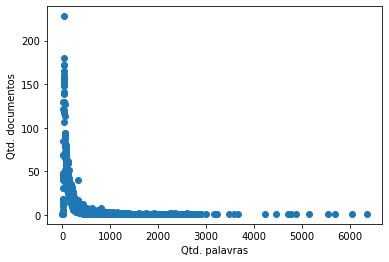

In [12]:
max_length = chart_palavras_por_documento(sequences)
chart_frequencia_palavras(df, 'texto_clean_pure', n_words=15)

#### Criação do modelo

In [13]:
X = _pad(sequences, max_length)
Y = df['categoria_binaria']

In [14]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42) # 80% treino
x_validation, x_test, y_validation, y_test,  = train_test_split(x_test, y_test, test_size=0.5, random_state=42) # 10% teste e 10% validação

print('Shapes de TRAIN - x_train={} e y_train={}'.format(np.shape(x_train), np.shape(y_train)))
print('Shapes de VALIDATION - x_validation={} e y_validation={}'.format(np.shape(x_validation), np.shape(y_validation)))
print('Shapes de TEST - x_test={} e y_test={}'.format(np.shape(x_test), np.shape(y_test)))

Shapes de TRAIN - x_train=(11232, 782) e y_train=(11232,)
Shapes de VALIDATION - x_validation=(1404, 782) e y_validation=(1404,)
Shapes de TEST - x_test=(1404, 782) e y_test=(1404,)


#### Configuração da sessão do Keras

In [15]:
# sudo nano  /sys/bus/pci/devices/0000\:01\:00.0/numa_node
# sudo sh -c "echo '0' >> /sys/bus/pci/devices/0000\:01\:00.0/numa_node"

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.force_gpu_compatible = True
config.inter_op_parallelism_threads = 4
config.intra_op_parallelism_threads = 4

sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=config)
K.set_session(sess)

2023-04-20 23:33:23.476833: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-20 23:33:23.536234: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-04-20 23:33:23.536277: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: home-001
2023-04-20 23:33:23.536286: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: home-001
2023-04-20 23:33:23.536442: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.105.17
2023-04-20 23:33:23.536473: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 525.60.13
2023-04-20 23:33

#### Design da rede neural

In [16]:
model = Sequential()

# first hidden layer:
model.add(Embedding(n_unique_words, n_dim, input_length=max_length))
model.add(Flatten())

# second hidden layer:
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))

# output layer:
model.add(Dense(1, activation='sigmoid')) # mathmatically equivalent to softmax with two classes

# informações
print(model.summary())

print("embedding layer dimensions and parameters: {}".format((n_dim, n_unique_words, n_dim*n_unique_words)))
print("...flatten: {}".format((max_length, n_dim, max_length*n_dim)))
print("...dense: {}".format((n_dense, n_dim*max_length*n_dense + n_dense))) #weights + biases
print("...and output: {}".format((n_dense + 1)))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 782, 16)           1600016   
                                                                 
 flatten (Flatten)           (None, 12512)             0         
                                                                 
 dense (Dense)               (None, 64)                800832    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,400,913
Trainable params: 2,400,913
Non-trainable params: 0
_________________________________________________________________
None
embedding layer dimensions and parameters

#### Configuração do modelo

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

#### Treinamento e validação

In [18]:
history = model.fit(x_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_validation, y_validation))

Epoch 1/40
22/22 [==============================] - 2s 53ms/step - loss: 0.4859 - accuracy: 0.8557 - val_loss: 0.3851 - val_accuracy: 0.8647
Epoch 2/40
22/22 [==============================] - 1s 43ms/step - loss: 0.3790 - accuracy: 0.8767 - val_loss: 0.3851 - val_accuracy: 0.8661
Epoch 3/40
22/22 [==============================] - 1s 44ms/step - loss: 0.3796 - accuracy: 0.8813 - val_loss: 0.3785 - val_accuracy: 0.8661
Epoch 4/40
22/22 [==============================] - 1s 45ms/step - loss: 0.3725 - accuracy: 0.8819 - val_loss: 0.3756 - val_accuracy: 0.8675
Epoch 5/40
22/22 [==============================] - 1s 46ms/step - loss: 0.3677 - accuracy: 0.8836 - val_loss: 0.3723 - val_accuracy: 0.8689
Epoch 6/40
22/22 [==============================] - 1s 43ms/step - loss: 0.3632 - accuracy: 0.8857 - val_loss: 0.3688 - val_accuracy: 0.8732
Epoch 7/40
22/22 [==============================] - 1s 43ms/step - loss: 0.3592 - accuracy: 0.8876 - val_loss: 0.3649 - val_accuracy: 0.8754
Epoch 8/40
22

#### Aplicação na base de testes

In [19]:
# Apply a sigmoid since our model returns logits
# predictions = tf.nn.sigmoid(predictions)
# predictions = tf.where(predictions < 0.5, 0, 1)

p_hat = model.predict_on_batch(x_test).flatten()
y_hat = [0 if probability < 0.5 else 1 for probability in p_hat]

#### Geração de estatísticas

              precision    recall  f1-score   support

           0     0.9239    0.9733    0.9479      1235
           1     0.6796    0.4142    0.5147       169

    accuracy                         0.9060      1404
   macro avg     0.8018    0.6937    0.7313      1404
weighted avg     0.8945    0.9060    0.8958      1404



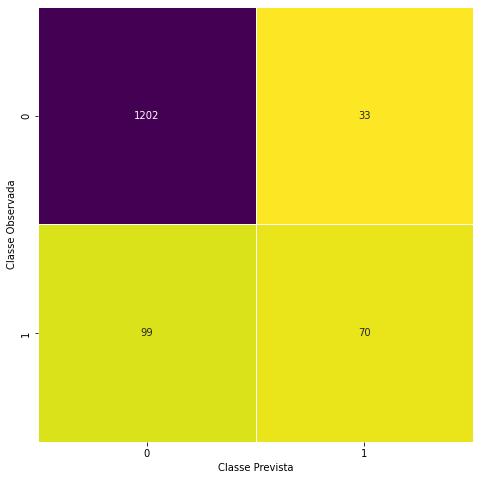

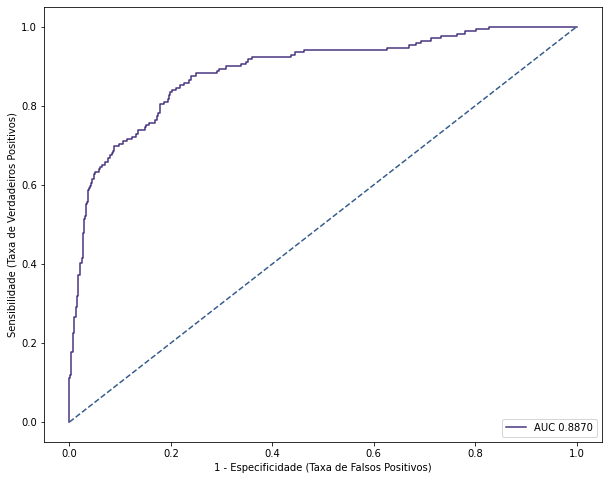

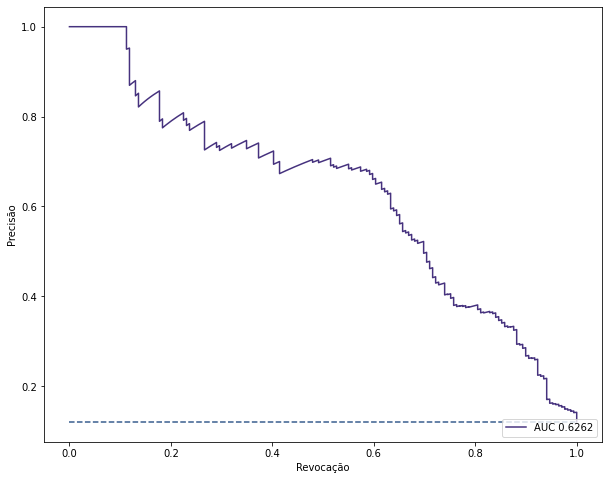

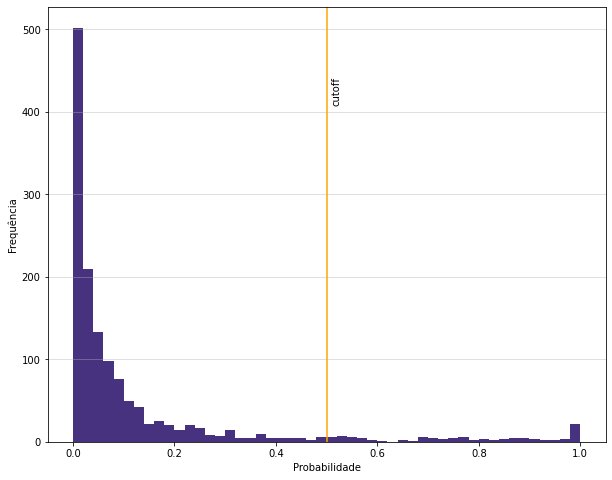

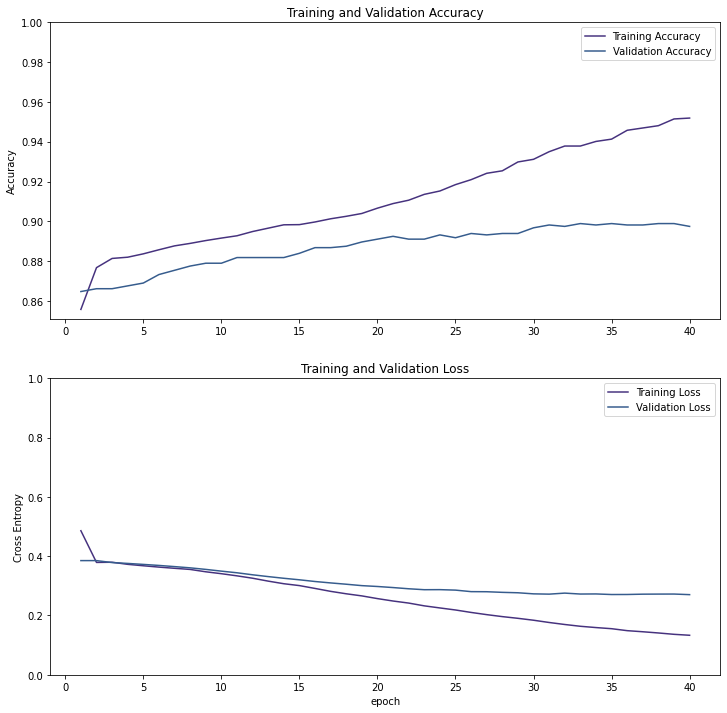

44/44 [==============================] - 0s 2ms/step - loss: 0.2398 - accuracy: 0.9060
Test accuracy: 0.9060
Test loss: 0.2398


In [20]:
_matrix_confusao(y_test, y_hat)
_curva_roc(y_test, p_hat)
_precision_recall(y_test, p_hat, y_hat)
_histograma(p_hat)
_ephoc_loses(history)

loss, accuracy = model.evaluate(x_test, y_test)

print('Test accuracy: {:0.4f}'.format(accuracy))
print('Test loss: {:0.4f}'.format(loss))